In [1]:
import os
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds

2024-06-05 13:44:55.983077: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 13:44:57.595156: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 13:45:13.166221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
builder = tfds.ImageFolder("Img_dataset")
print(builder.info)

In [ ]:
train = builder.as_dataset(split='train', shuffle_files=False)
tfds.show_examples(train, builder.info)

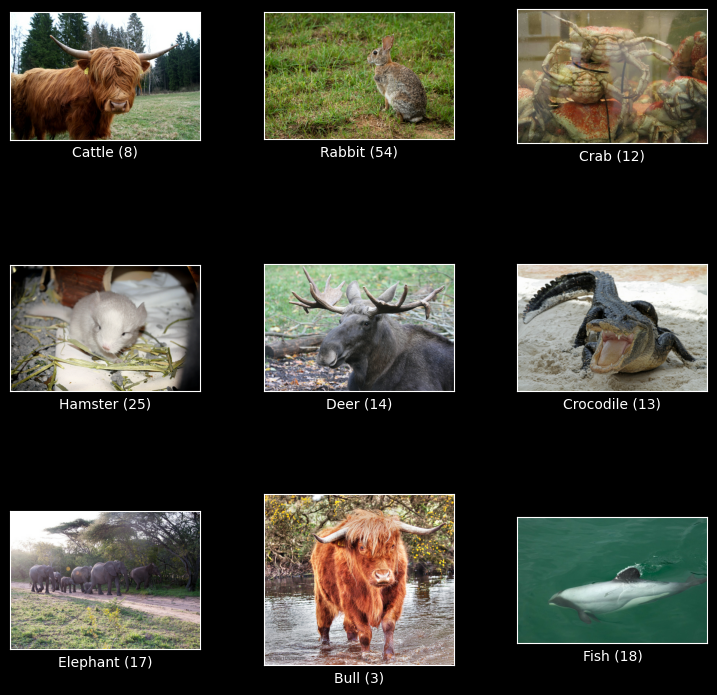

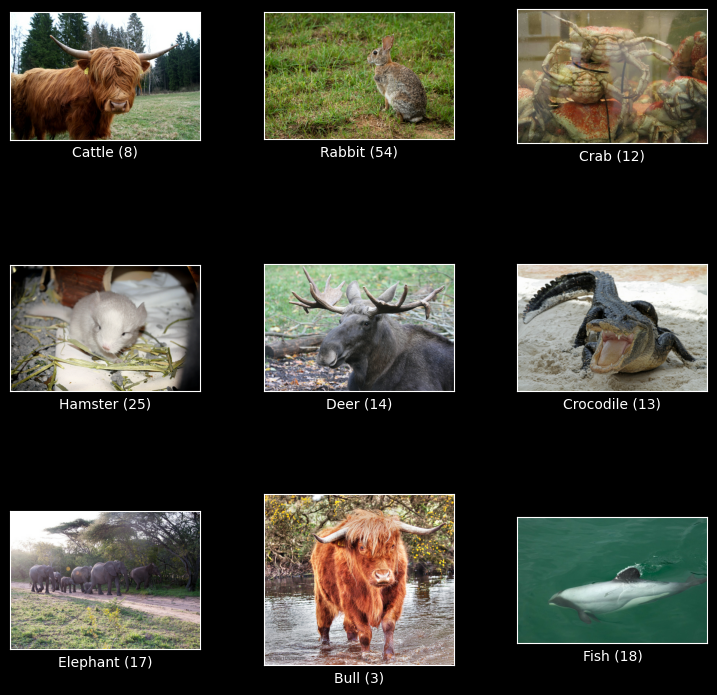

In [4]:
test = builder.as_dataset(split='test', shuffle_files=False)
tfds.show_examples(test, builder.info)

In [5]:
builder.info.splits.keys()

dict_keys(['test', 'train'])

In [6]:
def count(ds):
    n = 0
    for _ in ds:
        n += 1
    return n

print('Train dataset: {}'.format(count(train)))

Train dataset: 22566


In [7]:
print('Test dataset: {}'.format(count(test)))

Test dataset: 6505


In [9]:
train_ds = train.take(16000)
valid_ds = train.take(1000)

print('Train dataset: {}'.format(count(train_ds)))

Train dataset: 16000


In [10]:
print('Train dataset: {}'.format(count(valid_ds)))

Train dataset: 1000


- Transformation and Augmentation.

In [11]:
samples = []

for sample in train_ds.take(5):
    samples.append(sample['image'])

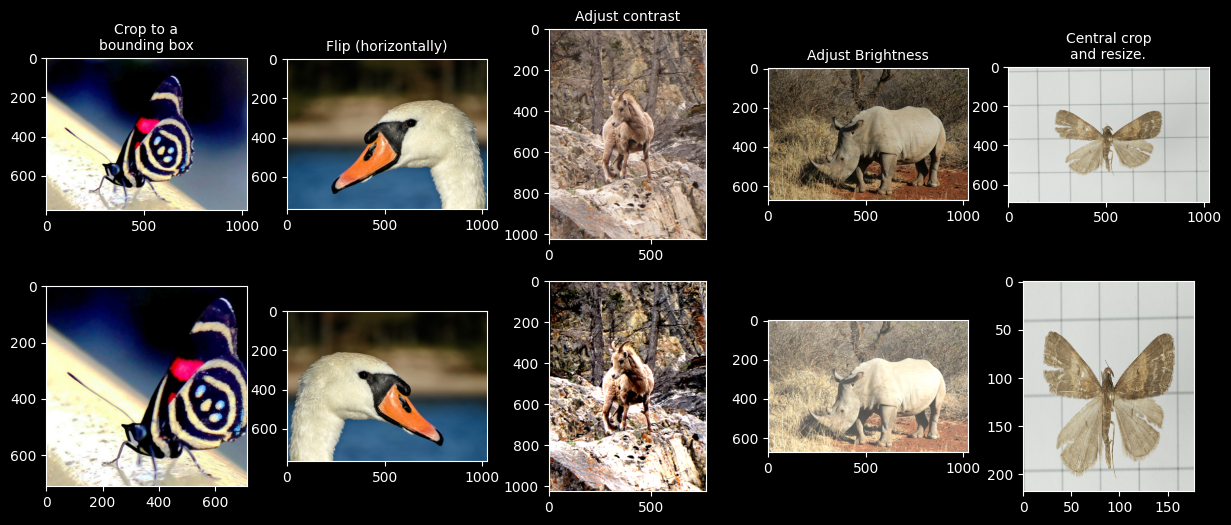

In [23]:
fig  = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 5, 1)
ax.set_title('Crop to a\nbounding box', size=10)
ax.imshow(samples[0])
ax = fig.add_subplot(2, 5, 6)
img_crop = tf.image.crop_to_bounding_box(samples[0], 50, 20, 712, 712)
ax.imshow(img_crop)

ax = fig.add_subplot(2, 5, 2)
ax.set_title('Flip (horizontally)', size=10)
ax.imshow(samples[2])
ax = fig.add_subplot(2, 5, 7)
img_flip = tf.image.flip_left_right(samples[2])
ax.imshow(img_flip)

ax = fig.add_subplot(2, 5, 3)
ax.set_title('Adjust contrast', size=10)
ax.imshow(samples[1])
ax = fig.add_subplot(2, 5, 8)
img_cont = tf.image.adjust_contrast(samples[1], contrast_factor=2)
ax.imshow(img_cont)

ax = fig.add_subplot(2, 5, 4)
ax.set_title('Adjust Brightness', size=10)
ax.imshow(samples[3])
ax = fig.add_subplot(2, 5, 9)
img_bright = tf.image.adjust_brightness(samples[3], delta=0.3)
ax.imshow(img_bright)

ax = fig.add_subplot(2, 5, 5)
ax.set_title('Central crop\nand resize.', size=10)
ax.imshow(samples[4])
ax = fig.add_subplot(2, 5, 10)
img_crop = tf.image.central_crop(samples[4], central_fraction=0.7)
img_resize = tf.image.resize(img_crop, size=(218, 178))
ax.imshow(img_resize.numpy().astype('uint8'))

plt.show()

In [ ]:
tf.random.set_seed(1)

fig = plt.figure(figsize=(15, 6))

for i, sample in enumerate(train_ds.take(3)):
    image = sample['image']

    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(image)
    if i == 0:
        ax.set_title('Original', size=10)
        
    ax = fig.add_subplot(3, 4, i*4+2)
    img_crop = tf.image.random_crop(image, size=(178, 178, 3))
    ax.imshow(img_crop)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=10)
        
    ax = fig.add_subplot(3, 4, i*4+3)
    img_flip = tf.image.random_flip_left_right(img_crop)
    ax.imshow(tf.cast(img_flip, tf.uint8))
    if i == 0:
        ax.set_title('Step 2: Random flip', s)

- Preprocessing.

In [7]:
from dataclasses import dataclass

@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = len(builder.info.features['label'].names)
    IMG_HEIGT: int = 64
    IMG_WIDTH: int = 64
    
@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS: int = 100
    BATCH_SIZE: int = 256
    LEARNING_RATE: int = 0.001

In [13]:
assert isinstance(train, tf.data.Dataset)

In [14]:
example = next(iter(train))
print(example.keys())

dict_keys(['image', 'image/filename', 'label'])


In [31]:
def preprocess_dataset(dataset: tf.data.Dataset, shuffle: bool = False):
    def preprocess_image(image):
        # img = tf.image.convert_image_dtype(image, tf.float32)
        img = tf.image.resize_with_pad(image, 
                                       target_height=DatasetConfig.IMG_HEIGT,
                                       target_width=DatasetConfig.IMG_WIDTH)
        img /= 255.0
        
        return img
    
    ds = dataset.cache()
    ds = ds.map(preprocess_image)
    ds = ds.batch(batch_size=TrainingConfig.BATCH_SIZE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return ds

In [32]:
preprocess_dataset(train)

TypeError: in user code:

    File "<ipython-input-31-211a5b2d1cad>", line 4, in preprocess_image  *
        img = tf.image.resize_with_pad(image,

    TypeError: Expected any non-tensor type, but got a tensor instead.
